# Basics of Filtering

In order to understand what filters do, we will consider the Fourier Series of different functions:

A function infinitely many continuous derivatives (analytic):
$$f(x) = x \sin(\pi x)$$

A function that is continuous, but does not have continuous derivatives:
$$g(x) = \bigg|\sin(\pi x)\bigg|$$

And, lastly, a discontinous function
$$h(x) = \begin{cases}1,\quad & x \in \left(-\frac{1}{2},\frac{1}{2}\right)\\
0,\quad & \text{else}
\end{cases}$$


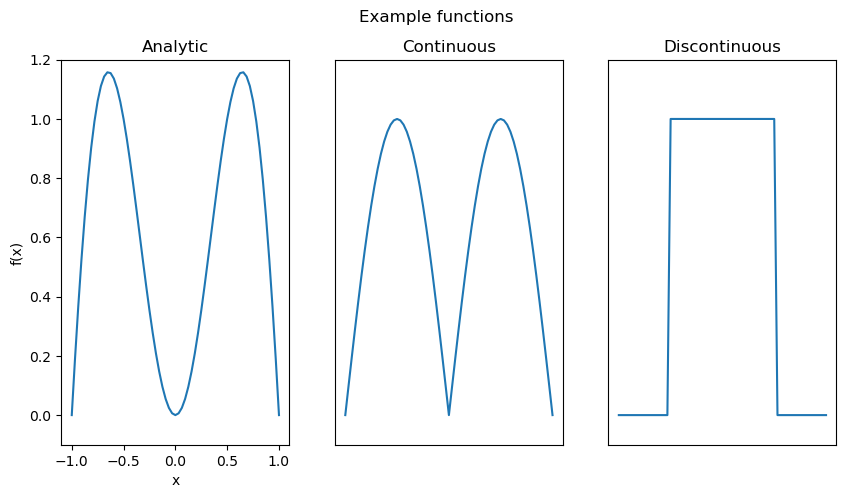

In [3]:

# import necessary stuff for code
import numpy as np
import sympy as sym
import scipy
import matplotlib.pyplot as plt
import math

# reset figure size
plt.rcParams['figure.figsize'] = [10, 5]

# define domain
xLeft = -1
xRight = 1
domainlen = xRight - xLeft

# discretize domain
Nx = 64
x = np.linspace(xLeft,xRight,Nx+1)

# exact functions
fexact = np.zeros((3,Nx+1))
fexact[0,:] = 2*x*np.sin(np.pi*x)
fexact[1,:]= abs(np.sin(np.pi*x))
fexact[2,:]= np.piecewise(x, [x < -0.5, -0.5 <= x , x > 0.5], [0, 1, 0])

plt.figure()
plt.suptitle('Example functions')

# plot functions
for m in np.arange(3):
    if m == 0:
        plt.subplot(131)
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.title('Analytic')
    elif m == 1:
        plt.subplot(132)
        plt.title('Continuous')
    else:
        plt.subplot(133)
        plt.title('Discontinuous')

    plt.plot(x,fexact[m,:])
    plt.ylim([-0.1,1.2])

    if m!= 0:
        plt.yticks([])
        plt.xticks([])


In order to understand what filters do, we will consider the Fourier Series of a function:
$$f(x) = \frac{a_0}{2} + \sum_{n=1}^\infty\, \left(a_n\cos(\omega_n x) + b_n\sin(\omega_n x)\right), \qquad x \in \Omega = [x_L,x_R],$$
with $\omega_n = \frac{2\pi}{|\Omega|},\, |\Omega| = x_R-x_L$ and
$$a_n = \frac{2}{| \Omega |}\int_{\Omega}\, f(x)\cos(\omega_n x)\, dx,\quad b_n = \frac{2}{|\Omega|}\int_{\Omega}\, f(x)\sin(\omega_n x)\, dx.$$
We will specifically investigate the decay of the coefficients:
$$\hat{f_n} = \sqrt{a_n^2 + b_n^2}.$$

Of course, we will need the truncated series...

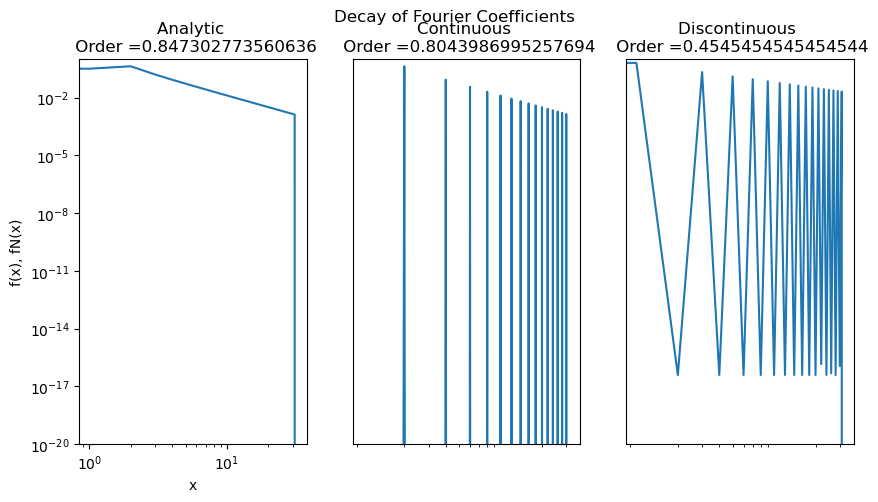

In [4]:
# Truncated trignometric Fourier series

N = 64 # number of Fourier coefficients if we would use the exponential series
Nhalf = int(N/2) # coefficients for cosine series
nwav = np.linspace(0, Nhalf, Nhalf + 1) # wavenumber
omegan = (2*np.pi/domainlen)*nwav

fcos = np.zeros((Nhalf+1,3))
fsin = np.zeros((Nhalf+1,3))
fhat = np.zeros((Nhalf+1,3))
fhatorders = np.zeros((Nhalf+1,3))  #np.zeros((Nhalf+1,3))

# Exact Fourier coefficients for analytic function
fcos[0,0] = 2/np.pi
fcos[1,0] = -1/np.pi
fcos[2:Nhalf,0] = 4*np.divide((-1)**(nwav[2:Nhalf]+1),(np.pi*(nwav[2:Nhalf]**2-1)))

# Exact Fourier coefficients for continuous function, with no continuous derivatives
fcos[0,1] = 2/np.pi
fcos[1,1]= 0.0
fcos[2:Nhalf,1] = -2*np.divide((1+(-1)**nwav[2:Nhalf]),(np.pi*(nwav[2:Nhalf]**2-1)))

# Fourier coefficients for discontinuous function
fcos[0,2] = 0.5
fcos[1:Nhalf,2] = np.divide(np.sin(0.5*np.pi*nwav[1:Nhalf] ),(0.5*np.pi*nwav[1:Nhalf] ))

plt.figure()
plt.suptitle('Decay of Fourier Coefficients')
# Fourier coefficients for exponential series.
for m in np.arange(3):
    fhat[:,m] = np.sqrt(fcos[:,m]**2 + fsin[:,m]**2)

    # Calculate order of decay using fhat(n) decays on the order of (1/n)^m ==> m = log(fhat(n+2)/fhat(n))/log(n/n+2)
    if m == 0:
        fhatorders[2:Nhalf:2,m] = np.divide(np.log(np.divide(fhat[1:Nhalf-1:2,m],fhat[2:Nhalf:2,m])),np.log(np.divide(nwav[2:Nhalf:2],nwav[1:Nhalf-1:2])))
    elif m == 1:
        fhatorders[4:Nhalf-2:2,m] = np.divide(np.log(np.divide(fhat[2:Nhalf-4:2,m],fhat[4:Nhalf-2:2,m])),np.log(np.divide(nwav[4:Nhalf-2:2],nwav[2:Nhalf-4:2])))
    elif m == 2:
        fhatorders[3:Nhalf:2,m] = np.divide(np.log(np.divide(fhat[1:Nhalf-2:2,m],fhat[3:Nhalf:2,m])),np.log(np.divide(nwav[3:Nhalf:2],nwav[1:Nhalf-2:2])))

    if m == 0:
        plt.subplot(131)
        plt.xlabel('x')
        plt.ylabel('f(x), fN(x)')
        plt.title('Analytic \n Order ='+str(np.mean(fhatorders[:,m])))
    elif m == 1:
        plt.subplot(132)
        plt.title('Continuous \n Order ='+str(np.mean(fhatorders[:,m])))
    else:
        plt.subplot(133)
        plt.title('Discontinuous \n Order ='+str(np.mean(fhatorders[:,m])))


    plt.loglog(nwav,fhat[:,m])
    plt.ylim([10**(-20),10**0])

    if m != 0:
        plt.yticks([])
        plt.xticks([])


# Truncated Fourier Series Approximation (Spectral)

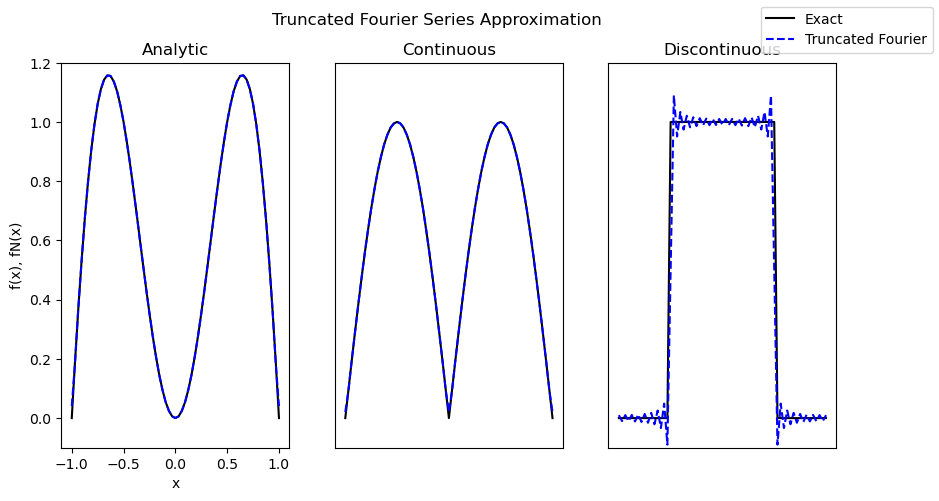

In [5]:
# Truncated Fourier Series Approximation (Spectral)

Costerm = np.zeros((Nx+1,Nhalf+1))
Sinterm = np.zeros((Nx+1,Nhalf+1))
for n in np.arange(Nhalf+1):
    Costerm[:,n] = np.cos(omegan[n]*x)
    Sinterm[:,n] = np.sin(omegan[n]*x)

FS = np.zeros((3,Nx+1))

plt.figure()
plt.suptitle('Truncated Fourier Series Approximation')

for m in np.arange(3): # loop over functions
    for j in np.arange(Nx+1): # loop over x
        FS[m,j] = np.dot(fcos[:,m],Costerm[j,:])+np.dot(fsin[:,m],Sinterm[j,:])

    if m == 0:
        plt.subplot(131)
        plt.xlabel('x')
        plt.ylabel('f(x), fN(x)')
        plt.title('Analytic')
    elif m == 1:
        plt.subplot(132)
        plt.title('Continuous')
    else:
        plt.subplot(133)
        plt.title('Discontinuous')

    plt.plot(x,fexact[m,:],'k',x,FS[m,:],'b--')
    plt.ylim([-0.1,1.2])

    if m!= 0:
        plt.yticks([])
        plt.xticks([])

plt.figlegend(['Exact','Truncated Fourier'],loc='outside upper right')


# Common Filters

Let us now look at what some standard filters do to the Fourier coefficients.  We will consider:

**Cesáro Filter:** $$\sigma(\eta) = 1 - \eta$$
**Lanczos Filter:** $$\sigma(\eta) = \frac{\sin(\pi\eta)}{\pi\eta}$$
**Dirichlet Filter:** $$\sigma(\eta) =\frac{\sin(\frac{\pi}{2}(N+1)(\eta+1))}{\frac{\pi}{2}(\eta+1)}$$
**Raised Cosine Filter:** $$\sigma(\eta) =\frac{1}{2}\left(1+\cos(\pi\eta)\right)$$


([], [])

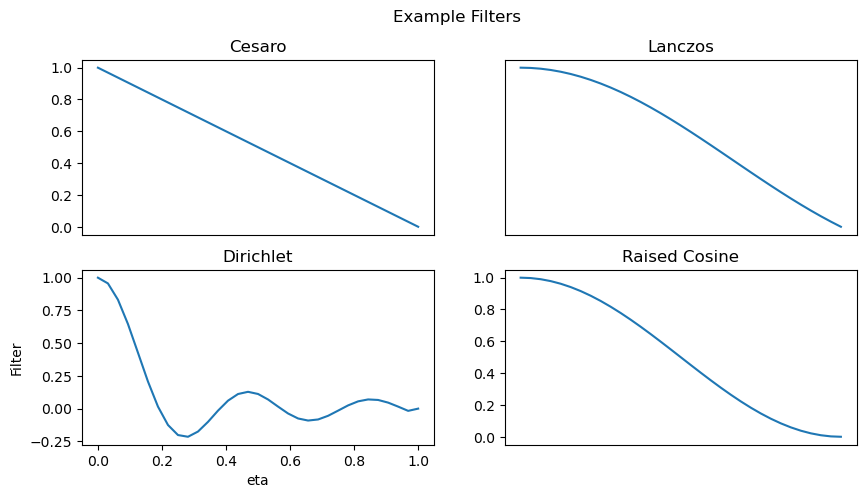

In [6]:
# filter variable
eta = nwav/Nhalf

# filter definitions
filter = np.zeros((Nhalf+1,5))

# Cesáro
filter[:,0] = 1 - eta

#Lanczos
filter[0,1] = 1.0
filter[1:Nhalf,1] = np.divide(np.sin(np.pi*eta[1:Nhalf]),(np.pi*eta[1:Nhalf]))


#Dirichlet
filter[0,2] = 1.0
filter[1:Nhalf,2] = np.divide(np.sin(0.5*(Nhalf+1)*eta[1:Nhalf]),(0.5*(Nhalf+1)*eta[1:Nhalf]))

#Raised cosine
filter[0:Nhalf,3] = 0.5*(1 + np.cos(np.pi*eta[0:Nhalf]))

plt.figure()
plt.suptitle('Example Filters')

plt.subplot(221)
plt.plot(eta,filter[:,0])
plt.title('Cesaro')
plt.xticks([])

plt.subplot(222)
plt.plot(eta,filter[:,1])
plt.title('Lanczos')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.plot(eta,filter[:,2])
plt.xlabel('eta')
plt.ylabel('Filter')
plt.title('Dirichlet')

plt.subplot(224)
plt.plot(eta,filter[:,3])
plt.title('Raised Cosine')
plt.xticks([])



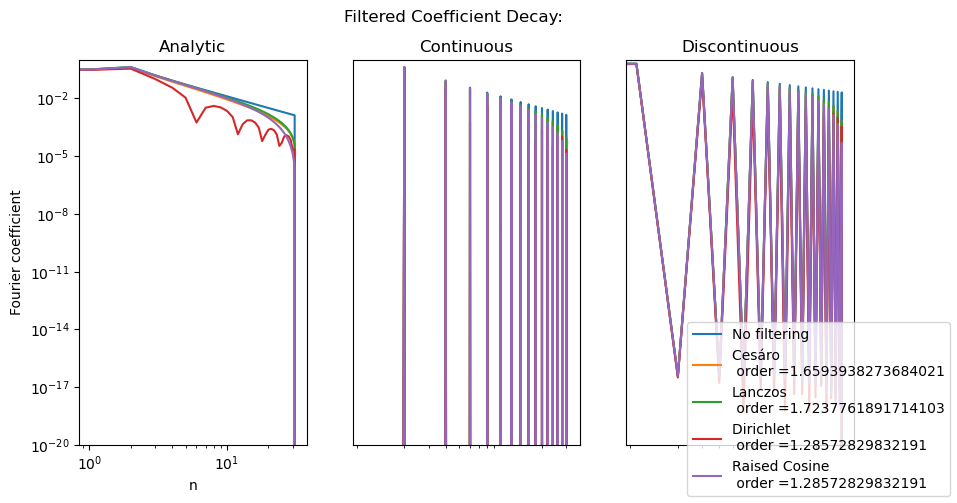

In [8]:
# Modified coefficients

fcosmod = np.zeros((Nhalf+1,3,5))
fsinmod = np.zeros((Nhalf+1,3,5))
fhatmod = np.zeros((Nhalf+1,3,5))
fhatmodorders = np.zeros((Nhalf+1,3,5))

plt.figure()
plt.suptitle('Filtered Coefficient Decay:')
for m in np.arange(3):

    for mfilter in np.arange(4):
        # filtered cosine/sine coefficients --> in terms of Nhalf
        fcosmod[:,m,mfilter] = np.multiply(filter[:,mfilter],fcos[:,m])
        fsinmod[:,m,mfilter] = np.multiply(filter[:,mfilter],fsin[:,m])
        # Filtered Fourier Coefficients for exponential series.
        fhatmod[:,m,mfilter] = np.sqrt(fcosmod[:,m,mfilter]**2 + fsinmod[:,m,mfilter]**2)

        if m == 0:
            fhatmodorders[2:Nhalf:2,m,mfilter] = np.divide(np.log(np.divide(fhatmod[1:Nhalf-1:2,m,mfilter],fhatmod[2:Nhalf:2,m,mfilter])),np.log(np.divide(nwav[2:Nhalf:2],nwav[1:Nhalf-1:2])))
        elif m == 1:
            fhatmodorders[4:Nhalf-2:2,m,mfilter] = np.divide(np.log(np.divide(fhatmod[2:Nhalf-4:2,m,mfilter],fhatmod[4:Nhalf-2:2,m,mfilter])),np.log(np.divide(nwav[4:Nhalf-2:2],nwav[2:Nhalf-4:2])))
        elif m == 2:
            fhatmodorders[3:Nhalf:2,m,mfilter] = np.divide(np.log(np.divide(fhatmod[1:Nhalf-2:2,m,mfilter],fhatmod[3:Nhalf:2,m,mfilter])),np.log(np.divide(nwav[3:Nhalf:2],nwav[1:Nhalf-2:2])))

    if m == 0:
        plt.subplot(131)
        plt.xlabel('n')
        plt.ylabel('Fourier coefficient')
        plt.title('Analytic')
    elif m == 1:
        plt.subplot(132)
        plt.title('Continuous')
    else:
        plt.subplot(133)
        plt.title('Discontinuous')

    # plot original coefficient decay
    if mfilter == 0:
        plt.loglog(nwav,fhat[:,m])
    plt.loglog(nwav,fhat[:,m])
    plt.ylim([10**(-20),10**0])

    for mfilter in np.arange(4):
        plt.loglog(nwav,fhatmod[:,m,mfilter])
        plt.ylim([10**(-20),10**0])

    if m == 2:
        plt.figlegend(['No filtering','Cesáro \n order ='+str(np.mean(fhatmodorders[:,m,0])),'Lanczos\n order ='+str(np.mean(fhatmodorders[:,m,1])),'Dirichlet \n order ='+str(np.mean(fhatmodorders[:,m,2])),'Raised Cosine \n order ='+str(np.mean(fhatmodorders[:,m,2]))], loc='outside lower right')

    if m != 0:
        plt.yticks([])
        plt.xticks([])



# Filtered Fourier Series Approximation


(33, 3, 5)


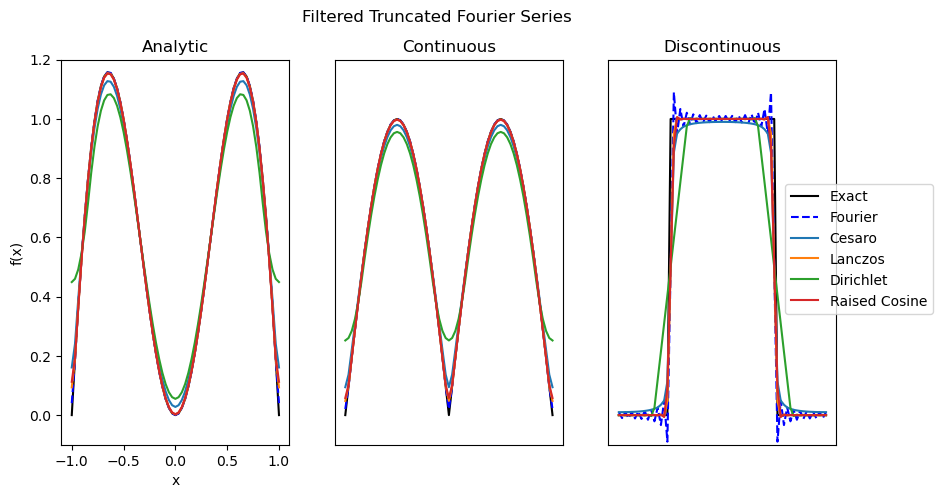

In [9]:
# Plot filtered functions
print(np.shape(fcosmod))
FSmod = np.zeros((3,5,Nx+1))
plt.figure()
plt.suptitle('Filtered Truncated Fourier Series')
for m in np.arange(3): # Loop over functions
    for mfilter in np.arange(4): # Loop over filters
        for j in np.arange(Nx+1): # Loop over x
            FSmod[m,mfilter,j] = np.dot(fcosmod[:,m,mfilter],Costerm[j,:])+np.dot(fsinmod[:,m,mfilter],Sinterm[j,:])

    if m == 0:
        plt.subplot(131)
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.title('Analytic')
    elif m == 1:
        plt.subplot(132)
        plt.title('Continuous')
    else:
        plt.subplot(133)
        plt.title('Discontinuous')

    plt.plot(x,fexact[m,:],'k',x,FS[m,:],'b--')
    plt.plot(x,FSmod[m,0,:],x,FSmod[m,1,:],x,FSmod[m,2,:],x,FSmod[m,3,:])
    plt.ylim([-0.1,1.2])

    if m != 0:
        plt.yticks([])
        plt.xticks([])

plt.figlegend(['Exact','Fourier','Cesaro','Lanczos','Dirichlet','Raised Cosine'],loc='outside center right')

## The Filter that technically is not a filter, i.e. *Exponential Filter*

The exponential filter technically does not satisfy the definition of a filter, but is often used.  It is defined as
$$\sigma(\eta) =  \begin{cases} 1, \quad & \eta \le |\eta_c| \\
 \text{exp}(-\alpha(\frac{\eta-\eta_c}{1-\eta_c})^m) \quad & |\eta| \ge \eta_c
 \end{cases}$$



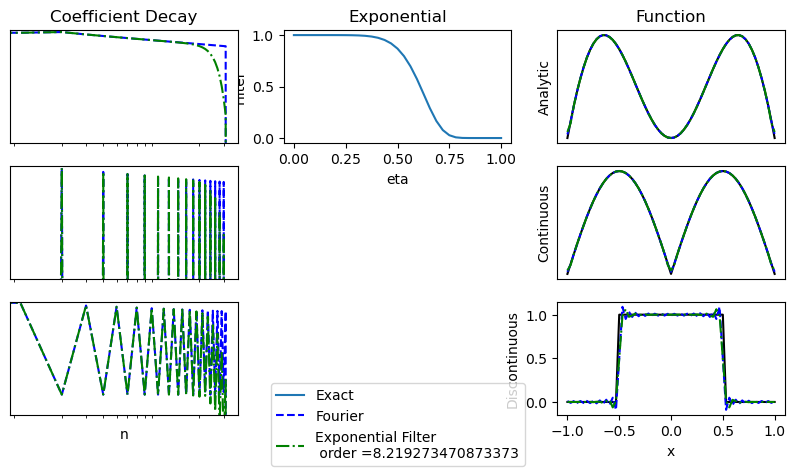

In [10]:
# Exponential filter
# Increasing m and/or etacutoff decreases the dissipation while increasing
# alpha has the opposite effect.
morder = 8
alpha = 36.0
etacutoff = 0.0

etatilda = -alpha*(np.divide((eta-etacutoff),(1-etacutoff)))**morder
filter[:,4] = np.piecewise(eta, [eta < etacutoff, eta >= etacutoff], [1, np.exp(etatilda)])

plt.figure()
plt.subplot(332)
plt.plot(eta,filter[:,4])
plt.xlabel('eta')
plt.ylabel('Filter')
plt.title('Exponential')

for m in np.arange(3): # Loop over functions
    fcosmod[:,m,4] = np.multiply(filter[:,4],fcos[:,m])
    fsinmod[:,m,4] = np.multiply(filter[:,4],fsin[:,m])

    fhatmod[:,m,4] = np.sqrt(fcosmod[:,m,4]**2 + fsinmod[:,m,4]**2)

    fhatmodorders[4:Nhalf-1:2,m,4] = np.log(np.divide(fhatmod[2:Nhalf-3:2,m,4],fhatmod[4:Nhalf-1:2,m,4]))/np.log(np.divide(nwav[4:Nhalf-1:2],nwav[2:Nhalf-3:2]))


    for j in np.arange(Nx+1): # Loop over x
        FSmod[m,4,j] = np.dot(fcosmod[:,m,4],Costerm[j,:]) + np.dot(fsinmod[:,m,4],Sinterm[j,:])

    if m == 0:
        plt.subplot(331)
        plt.title('Coefficient Decay')
    elif m == 1:
        plt.subplot(334)
    else:
        plt.subplot(337)

    # plot original coefficient decay as well as modified
    plt.loglog(nwav,fhat[:,m],'b--')
    plt.loglog(nwav,fhatmod[:,m,4],'g-.')
    plt.ylim([10**(-20),10**0])
    if m !=2:
        plt.yticks([])
        plt.xticks([])

    if m == 2:
        plt.subplot(337)
        plt.xlabel('n')

    # plot function, original fourier series, and modified
    if m == 0:
        plt.subplot(333)
        plt.title('Function')
        plt.ylabel('Analytic')
    elif m == 1:
        plt.subplot(336)
        plt.ylabel('Continuous')
    else:
        plt.subplot(339)
        plt.ylabel('Discontinuous')
        plt.xlabel('x')

    # plot original coefficient decay as well as modified
    plt.plot(x,fexact[m,:],'k',x,FS[m,:],'b--',x,FSmod[m,4,:],'g-.')

    if m !=2:
        plt.yticks([])
        plt.xticks([])

    if m == 2:
        plt.subplot(337)
        plt.figlegend(['Exact','Fourier','Exponential Filter\n order ='+str(np.mean(fhatmodorders[:,m,4]))],loc='outside lower center')
        plt.yticks([])
        plt.xticks([])
